In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Activation
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import *
from google.colab import drive
import pathlib
import os

drive.mount('/content/gdrive', force_remount=True)
data_dir = "/content/gdrive/MyDrive/Notebooks/Covid19_dataset_project"
data_dir = pathlib.Path(data_dir)
!ls "/content/gdrive/MyDrive/Notebooks/Covid19_dataset_project"

BATCH_SIZE = 32


In [72]:
def load_train_validation_data(img_height=210, img_width=210):

  IMG_SIZE = (img_height, img_width)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

  return train_ds, val_ds


In [73]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

186


**DenseNet121 - this is our best model**

In [76]:
def plot_accuracy_graph(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()



In [82]:

img_height = 210
img_width = 210

train_ds, val_ds = load_train_validation_data(img_height, img_width)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 251 files belonging to 3 classes.
Using 201 files for training.
Found 251 files belonging to 3 classes.
Using 50 files for validation.


In [84]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Load the pre-trained ResNet model
densnet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(210, 210, 3))

# Freeze the layers of the pre-trained model
for layer in densnet_model.layers:
    layer.trainable = False

# Replace the output layer with a new layer for your task
x = Flatten()(densnet_model.output)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=densnet_model.input, outputs=x)
epochs=8
# Train the model on your own dataset
learning_rate = 2e-4
decay_steps = 10
decay_rate = 1

# Khởi tạo learning rate scheduler
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps, decay_rate)
optimizer1 = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer = optimizer1, loss = SparseCategoricalCrossentropy(from_logits=True),metrics =['accuracy'])
# model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=32)

Epoch 1/8
7/7 [==============================] - 53s 6s/step - loss: 3.6538 - accuracy: 0.5323 - val_loss: 2.9064 - val_accuracy: 0.5400
Epoch 2/8
7/7 [==============================] - 38s 6s/step - loss: 1.6754 - accuracy: 0.7861 - val_loss: 1.4205 - val_accuracy: 0.8000
Epoch 3/8
7/7 [==============================] - 34s 5s/step - loss: 1.1374 - accuracy: 0.8408 - val_loss: 0.7079 - val_accuracy: 0.8200
Epoch 4/8
7/7 [==============================] - 38s 6s/step - loss: 0.3679 - accuracy: 0.9403 - val_loss: 0.4782 - val_accuracy: 0.9200
Epoch 5/8
7/7 [==============================] - 38s 6s/step - loss: 0.1663 - accuracy: 0.9652 - val_loss: 0.3694 - val_accuracy: 0.9200
Epoch 6/8
7/7 [==============================] - 34s 6s/step - loss: 0.0805 - accuracy: 0.9701 - val_loss: 0.2222 - val_accuracy: 0.9600
Epoch 7/8
7/7 [==============================] - 38s 6s/step - loss: 0.0443 - accuracy: 0.9900 - val_loss: 0.2532 - val_accuracy: 0.9400
Epoch 8/8
7/7 [==========================

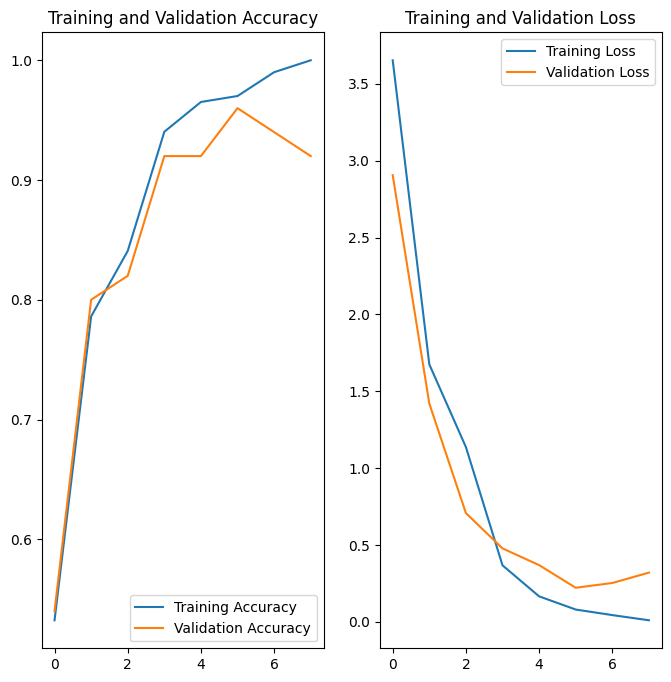

In [85]:
plot_accuracy_graph(history, epochs)

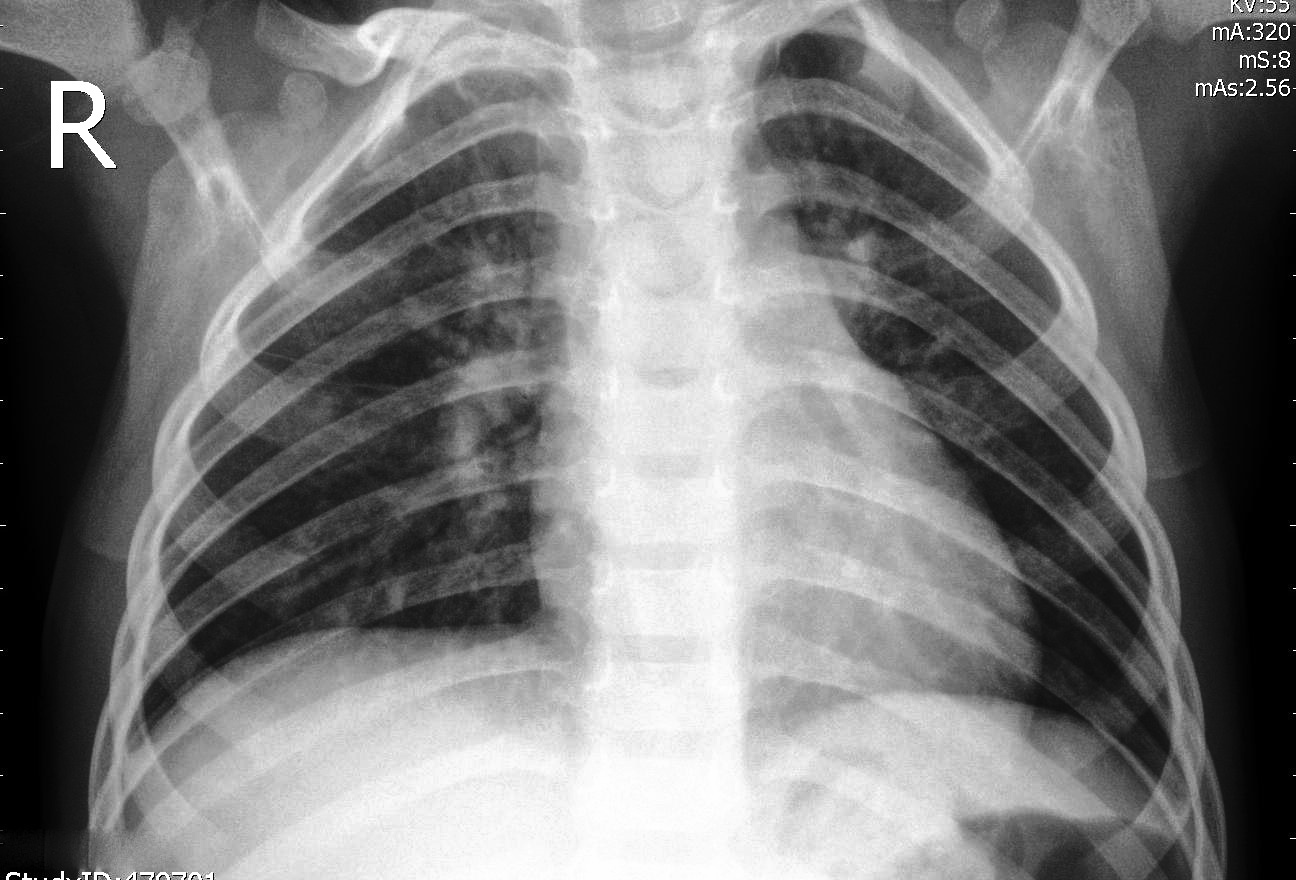

In [ ]:
first = list(data_dir.glob('01/*'))

PIL.Image.open(str(first[5]))

In [8]:
img_height=210
img_width=210
train_ds, val_ds = load_train_validation_data(img_height, img_width)
class_names = train_ds.class_names
print(class_names)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 251 files belonging to 3 classes.
Using 201 files for training.
Found 251 files belonging to 3 classes.
Using 50 files for validation.
['01', '02', '03']
(32, 210, 210, 3)
(32,)


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(20).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
print(train_ds)

0.0 1.0
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 210, 210, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 0


In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

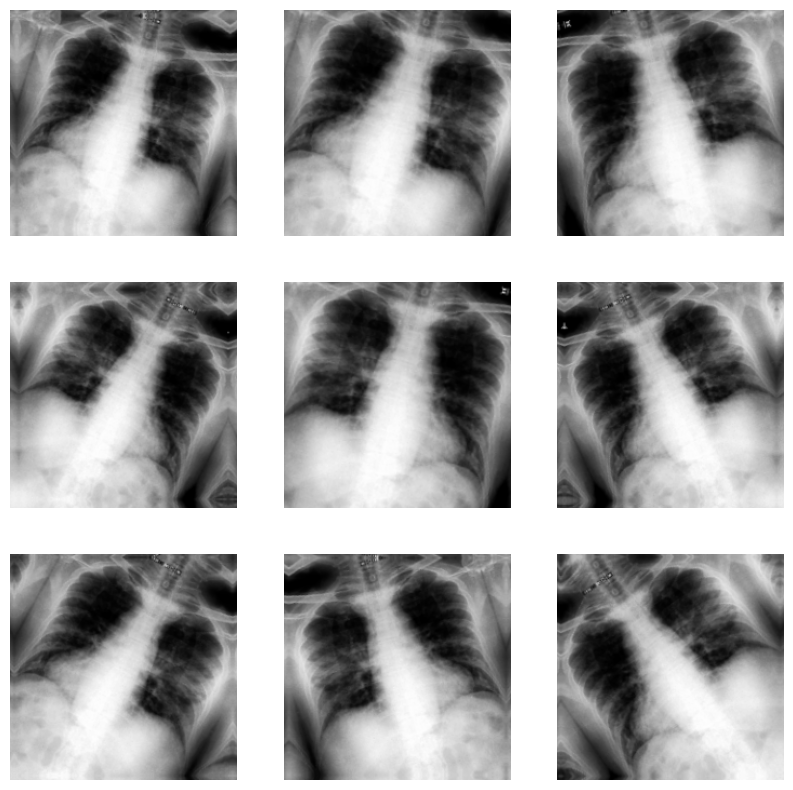

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**CNN reference model**

In [16]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
7/7 [==============================] - 21s 2s/step - loss: 1.2189 - accuracy: 0.3781 - val_loss: 0.9900 - val_accuracy: 0.4800
Epoch 2/20
7/7 [==============================] - 17s 2s/step - loss: 0.9329 - accuracy: 0.5672 - val_loss: 0.8122 - val_accuracy: 0.5600
Epoch 3/20
7/7 [==============================] - 17s 2s/step - loss: 0.6397 - accuracy: 0.7413 - val_loss: 0.8384 - val_accuracy: 0.5400
Epoch 4/20
7/7 [==============================] - 17s 2s/step - loss: 0.5512 - accuracy: 0.7463 - val_loss: 0.5735 - val_accuracy: 0.7600
Epoch 5/20
7/7 [==============================] - 17s 2s/step - loss: 0.4706 - accuracy: 0.7910 - val_loss: 0.5480 - val_accuracy: 0.7600
Epoch 6/20
7/7 [==============================] - 18s 2s/step - loss: 0.4656 - accuracy: 0.8259 - val_loss: 0.2932 - val_accuracy: 0.8400
Epoch 7/20
7/7 [==============================] - 16s 2s/step - loss: 0.4223 - accuracy: 0.8060 - val_loss: 0.3223 - val_accuracy: 0.8800
Epoch 8/20
7/7 [==================

In [ ]:
plot_accuracy_graph(history, epochs)

In [ ]:
model.save("vanilla_algo_with augmentation.keras")

**VGG**

In [55]:
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1) # set validation split

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 226 images belonging to 3 classes.
Found 25 images belonging to 3 classes.


In [56]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from keras import optimizers

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128, 3))
for layer in base_model.layers:
    layer.trainable = False

num_classes = len(class_names)

x = Flatten()(base_model.output)
prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction)

learning_rate = 2e-4
decay_steps = 10
decay_rate = 1

# Khởi tạo learning rate scheduler
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps, decay_rate)
optimizer1 = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer = optimizer1, loss = 'categorical_crossentropy',metrics =['accuracy'])

history = model.fit(train_generator, batch_size = BATCH_SIZE, epochs =epochs,validation_data =validation_generator, callbacks=[early_stop])

Epoch 1/12
8/8 [==============================] - 55s 6s/step - loss: 0.9797 - accuracy: 0.4779 - val_loss: 0.9173 - val_accuracy: 0.6800
Epoch 2/12
8/8 [==============================] - 57s 7s/step - loss: 0.8386 - accuracy: 0.6504 - val_loss: 0.8611 - val_accuracy: 0.5600
Epoch 3/12
8/8 [==============================] - 51s 6s/step - loss: 0.6943 - accuracy: 0.7876 - val_loss: 0.7280 - val_accuracy: 0.7200
Epoch 4/12
8/8 [==============================] - 51s 6s/step - loss: 0.5887 - accuracy: 0.8673 - val_loss: 0.6536 - val_accuracy: 0.8000
Epoch 5/12
8/8 [==============================] - 50s 6s/step - loss: 0.5316 - accuracy: 0.8717 - val_loss: 0.6232 - val_accuracy: 0.8000
Epoch 6/12
8/8 [==============================] - 52s 6s/step - loss: 0.4810 - accuracy: 0.8850 - val_loss: 0.6545 - val_accuracy: 0.7600
Epoch 7/12
8/8 [==============================] - 53s 6s/step - loss: 0.4301 - accuracy: 0.9027 - val_loss: 0.5697 - val_accuracy: 0.8400
Epoch 8/12
8/8 [==================

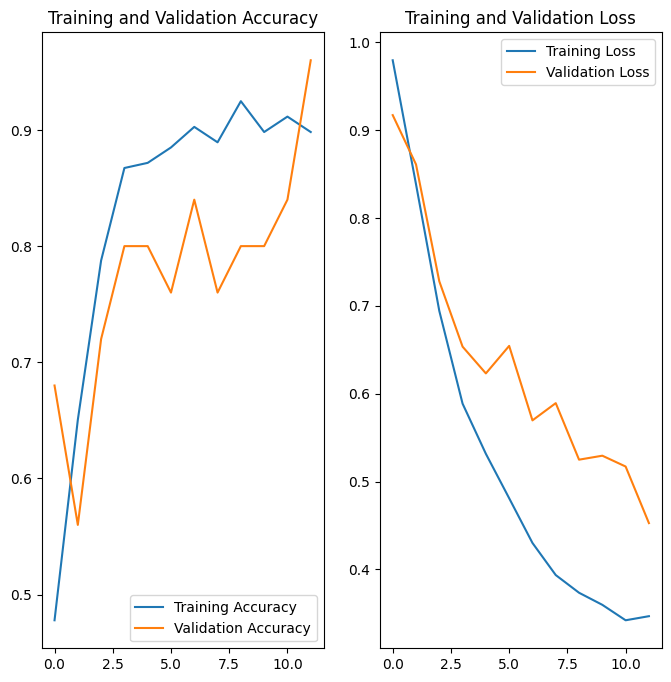

In [58]:
plot_accuracy_graph(history, 12)

In [ ]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [ ]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [ ]:
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_ds, (counter, counter)))

train_ds = (train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)